# Mit dem Red Pitaya das Echosignal eines Low Cost Ultraschallsensors erfassen und auswerten
Version 24.10.2021, S. Mack  

Der HC-SR04 ist ein low cost Ultraschallsensor. Er besitzt einen getrennten Sende- und Empfangstranceiver sowie eine integrierte Auswerteelektronik. Die beiden resonanten Transceiver sind gepaart, so dass sie beide die gleiche Resonanzfrequenz von ca. 40 kHz besitzen.

Der Sensor wird an VCC und GND mit 5 V Spannung versorgt. Die beiden anderen Pins TRIG und ECHO dienen zum Starten einer Messung bzw. zum Auslesen des Messergebnisses: Ein ca. 10 µs langer Puls an TRIG startet die Messung. Wurde vom Sensor ein Echo erkannt, so wird die Laufzeit  des ersten erkannten Echos als Pulsbreite (150 µs … 25 ms) am Pin ECHO ausgegeben. Eine Pulsbreite von 38 ms am Pin ECHO signalisiert, dass der Sensor kein Echo erkannt hat.

Aufgrund dieser Signalauswertung und der Pulsweiten-Schnittstelle kann der HC-SR04 weder die Echohöhe, eine Dopplerverschiebung oder die Laufzeit von mehreren Echos ausgeben. Dies ist nur möglich, wenn man Zugriff zum analogen Echosignal des  Empfangstranceiver erhält.
Wie auf dem Foto dargestellt, kann das verstärkte Echosignal an einem IC-Kontakt auf der Platinenrückseite abgegriffen und z.B. mit einem Oszilloskop gemessen werden.

![Rückseite Platine HC-SR04 Ultraschallsensor](HCSR04Sensor.JPG)

>Dieses Jupyter-Notebook kann nicht unter Binder sondern nur lokal auf einem PC ausgeführt werden, wobei das Modul `redpitaya_scpi.py` und die im Import der Skripte genannten Bibliotheken vorhanden sein müssen. **Unter Binder bzw. ohne angeschlossenen Red Pitaya sind nur die Pythonskripte zur Simulation und Auswertung der Messwerte, die als Textdateien im Verzeichnis dieses Notebooks vorliegen, ausführbar.**

In dem hier dargestelltem Versuchsaufbau wird dieses Signal von einem Red Pitaya (STEMlab 125-10) mit Hilfe eines Python-Skript aufgenommen, welches auf dessen SCPI-Server zugreift.  
Dabei erzeugt der Red Pitaya auf einem Pin seiner Stiftleisten auch das Start-Signal am Pin TRIG des HS-SR04. Die steigende Flanke des Signals vom Pin ECHO des HC-SR04 wird dazu verwendet, um die Signalabtastung durch den Red Pitaya zu triggern. Diese Flanke ist synchron mit dem Aussendezeitpunkt des 40 kHz Sendeburst am Ultraschallsensor.  

Der Red Pitaya verwendet 3,3 V Logik, der Ultraschallsensor hingegen eine 5 V Logik. Für das Signal vom Red Pitaya an den Pin TRIG des Ultraschallsensors ist dies ohne Bedeutung. Jedoch muss das 5 V Signal des Ultraschallsensors vom Pin ECHO durch einen 10 kΩ / 10 kΩ Teiler reduziert werden, bevor es dem Red Pitaya zugeführt wird.
Auf dem Foto ist der komplette Versuchsaufbau dargestellt.

![Kompletter Versuchsaufbau](MessaufbRedPitUltraschall.JPG)


## Messung des Echoverlaufs mit dem Red Pitaya
Der Red Pitaya tastet das Empfangssignal mit einer Abtastrate von ca. 1,953 MS/s (125 MS/s mit 64-fach Dezimierung) ab. Pro Ultraschallmessung werden dabei 16384 10 Bit Werte aufgenommen, was einer Abtastdauer von ca. 8,39 ms ab dem Sendeburst entspricht. Das Echosignal wird über einen 360 nF Kondensator (also nur dessen AC-Anteil) in den HF1-Eingang des Red Pitaya eingekoppelt.

Das nachfolgende Skript triggert den Ultraschallsensor, startet das Abtasten durch den Red Pitaya über den Pin ECHO des Sensors, stellt den aufgenommenen Echoverlauf dar und speichert ihn inkl. der Zeitwerte in eine Textdatei ab. Dazu muss vorher der SCPI-Server am Red Pitaya über dessen Web-Interface aktiviert werden.

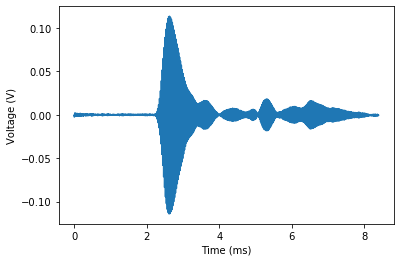

In [1]:
import time
import redpitaya_scpi as scpi
import numpy as np
import matplotlib.pyplot as plot

FILE_NAME = 'us_echo.txt'
DECIMATION = 64
SampPeriod = DECIMATION / 125e6  

rp_s = scpi.scpi('169.254.110.216')

period = 0.1 # seconds
buff_string = ''

rp_s.tx_txt('DIG:PIN:DIR OUT,DIO0_N')
rp_s.tx_txt('DIG:PIN  DIO0_N,'+ str(0))
rp_s.tx_txt('ACQ:RST')
rp_s.tx_txt('ACQ:DATA:FORMAT ASCII')
rp_s.tx_txt('ACQ:DATA:UNITS VOLTS')
rp_s.tx_txt('ACQ:DEC ' + str(DECIMATION))
rp_s.tx_txt('ACQ:TRIG:LEVEL 1')
rp_s.tx_txt('ACQ:TRIG:DLY 16000')
rp_s.tx_txt('ACQ:START')
rp_s.tx_txt('ACQ:TRIG EXT_NE')

time.sleep(period)
rp_s.tx_txt('DIG:PIN  DIO0_N,' + str(1))
time.sleep(0.0001)
rp_s.tx_txt('DIG:PIN  DIO0_N,' + str(0))

while 1:
    rp_s.tx_txt('ACQ:TRIG:STAT?')
    if rp_s.rx_txt() == 'TD':
        break

rp_s.tx_txt('ACQ:SOUR1:DATA?')
buff_string = rp_s.rx_txt()
buff_string = buff_string.strip('{}\n\r').replace("  ", "").split(',')

voltages = (np.asarray(buff_string)).astype(float)
times = np.arange(len(voltages)) * SampPeriod

meas_file = open(FILE_NAME,'w')
np.savetxt(FILE_NAME, (times,voltages))
meas_file.close()

plot.plot(times*1000, voltages)
plot.ylabel('Voltage (V)')
plot.xlabel('Time (ms)')
plot.show()

## Auswerten des Echoverlaufs
Genau wie für die Aufnahme des Echosignals wird auch für dessen Signalverabeitung ein Pythonskript verwendet.  

Die Aufgabe der Signalverarbeitung ist es, die Laufzeiten und Echohöhen der Mehrfachechos zu bestimmen. Dazu wird eine Quadraturdemodulation des Echosignals durchgeführt. Dadurch entsteht ein I- und ein Q-Signal, bei dem jeweils die (informationslose) Ultraschallträgerfrequenz aus dem Signal entfernt ist.  

Diese beiden Signale stellen quasi den Real- und Imaginärteil des momentanen Amplitudenvectors des Echos dar. Anders ausgedrückt kann mit dem I- und Q-Signal der zeitliche Verlauf der Echoamplitude und der Phase des Echosignals berechnet werden. 

Dies geschieht im folgenden Pythonskript, welches den Echoverlauf aus einer vorher durch eine Messung erzeugten Textdatei ausliest. Als Messwerte stehen die Dateien `us_echo_floor.txt` (Einzelecho, vertikale Messung auf Fußboden) und `us_echo_wall.txt`(Mehrfachechos, horizontale Messung auf Bücherregalwand) zur Auswahl.

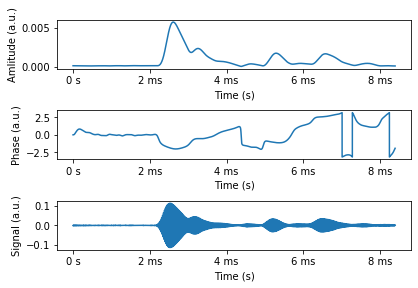

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from matplotlib.ticker import EngFormatter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

DECIMATION = 64 # Einstellung Decimation am Red Pitaya

order = 3 # Ordung des Filters 3
fs = 125e6 / DECIMATION   # Abtastrate der Signalwerte bzw. des Filters
cutoff = 4e3  # cut off frequency in Hz 4 kHz

FILE_NAME = 'us_echo_wall.txt' # mit Red Pitaya aufgenommenes Echosignal
#FILE_NAME = 'us_echo_floor.txt' # mit Red Pitaya aufgenommenes Echosignal
FREQ = 40.0e3 # Sendefrequenz des HC-SR04 (gemessen)

times,voltages = np.loadtxt(FILE_NAME)
cos = 0.1*np.cos(2*np.pi*FREQ*times)
sine = 0.1*np.sin(2*np.pi*FREQ*times)

sig_i = voltages * cos
sig_q = voltages * -sine

sig_i_filt = butter_lowpass_filter(sig_i, cutoff, fs, order)+ 0.0001
# Offset damit Rauschen um 0 kein Phasensprung verursacht
sig_q_filt = butter_lowpass_filter(sig_q, cutoff, fs, order)

sig_amp = np.sqrt(np.square(sig_i_filt)+np.square(sig_q_filt))
sig_phase = np.arctan2(sig_q_filt,sig_i_filt)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)
formatter1 = EngFormatter(unit='s')
ax0.xaxis.set_major_formatter(formatter1)
ax0.plot(times, sig_amp)
ax0.set_ylabel('Amlitude (a.u.)')
ax0.set_xlabel('Time (s)')
ax1.xaxis.set_major_formatter(formatter1)
ax1.plot(times, sig_phase)
ax1.set_ylabel('Phase (a.u.)')
ax1.set_xlabel('Time (s)')
ax2.xaxis.set_major_formatter(formatter1)
ax2.plot(times, voltages)
ax2.set_ylabel('Signal (a.u.)')
ax2.set_xlabel('Time (s)')
plt.tight_layout()

plt.show()

## Simulation eines Mehrfachechos und Signalverarbeitung
Das nachfolgend Pythonskript erzeugt ein künstliches Echosignal mit 3 zeitlich versetzen Echos, wendet darauf die  Quadraturdemodulation an und gibt den Amplituden- und Phasenverlauf grafisch aus.

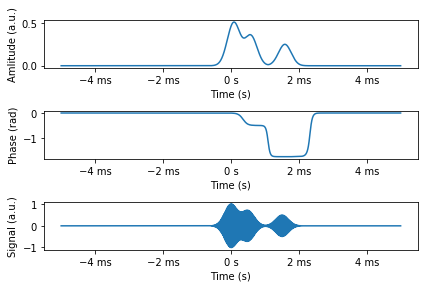

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, gausspulse
from matplotlib.ticker import EngFormatter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


order = 3 # Ordung des Filters 3
fs = 1e6   # Abtastrate der Signalwerte bzw. des Filters 1e6 Hz
cutoff = 4e3  # cut off frequency in Hz 4 kHz

FREQ = 40.0e3 # Trägerfrequenz 40 kHz
delay_sig_2 = 0.000502 # Delay zweiter Burst
atten_sig_2 = 0.7 # Dämpfung zweiter Burst
delay_sig_3 = 0.001507 # Delay zweiter Burst
atten_sig_3 = 0.5 # Dämpfung zweiter Burst

times = np.linspace(-0.005, 0.005, 2 * 5000, endpoint=False) # Zeitraum von +/- 5 ms
# Trägerfrequenz 40 kHz, Bandbreite 0.05*40 kHz = 200 Hz
burst_sig_1 = gausspulse(times, fc=40000, bw=0.05) 
burst_sig_2 = atten_sig_2 * gausspulse(times - delay_sig_2, fc=40000, bw=0.05) 
burst_sig_3 = atten_sig_3 * gausspulse(times - delay_sig_3, fc=40000, bw=0.05) 
cos = np.cos(2*np.pi*FREQ*times)
sine = np.sin(2*np.pi*FREQ*times)

burst = burst_sig_1 + burst_sig_2 + burst_sig_3

sig_i = burst * cos
sig_q = burst * -sine

sig_i_filt = butter_lowpass_filter(sig_i, cutoff, fs, order) + 0.0001
# Offset damit Rauschen um 0 kein Phasensprung verursacht
sig_q_filt = butter_lowpass_filter(sig_q, cutoff, fs, order)

sig_amp = np.sqrt(np.square(sig_i_filt)+np.square(sig_q_filt))
#sig_phase = np.arctan(sig_q_filt/sig_i_filt)
sig_phase = np.arctan2(sig_q_filt,sig_i_filt)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)

formatter1 = EngFormatter(unit='s')
ax0.xaxis.set_major_formatter(formatter1)
ax0.plot(times, sig_amp)
ax0.set_ylabel('Amlitude (a.u.)')
ax0.set_xlabel('Time (s)')
ax1.xaxis.set_major_formatter(formatter1)
ax1.plot(times, sig_phase)
ax1.set_ylabel('Phase (rad)')
ax1.set_xlabel('Time (s)')
ax2.xaxis.set_major_formatter(formatter1)
ax2.plot(times, burst)
#ax2.plot(times, sig_q_filt)
ax2.set_ylabel('Signal (a.u.)')
ax2.set_xlabel('Time (s)')
plt.tight_layout()

plt.show()